In [10]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from shapley import SobolIndices, SobolKrigingIndices, create_df_from_gp_indices, create_df_from_mc_indices
from shapley.tests import ishigami, ishigami_true_indices, additive_linear
from shapley.plots import set_style_paper, plot_violin, matrix_plot

import time

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


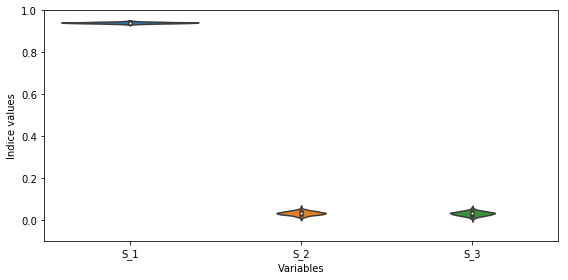

In [50]:
dim = 3
model = additive_linear
margins = [ot.Normal()]*dim
theta_12 = 0.5
theta_13 = 0.8
theta_23 = 0.
sigma = np.identity(dim)
sigma[1, 0] = theta_12
sigma[0, 1] = theta_12
sigma[2, 0] = theta_13
sigma[0, 2] = theta_13
sigma[2, 1] = theta_23
sigma[1, 2] = theta_23
    
copula = ot.NormalCopula(ot.CorrelationMatrix(sigma))
input_distribution = ot.ComposedDistribution(margins, copula)
ot.RandomGenerator.SetSeed(0)
    
max_budget = 10000
n_sample = 10000
n_boot = 1000
ylim = [-0.1, 1.]

sobol = SobolIndices(input_distribution)
sobol.build_uncorrelated_mc_sample(model, n_sample)
#sobol.build_mc_sample(model, n_sample)
first_indices_mc = sobol.compute_indices(n_boot=n_boot, estimator='sobol')
df_first_indices_mc = create_df_from_mc_indices(first_indices_mc)
plot_violin(df_first_indices_mc, with_hue=False, ylim=ylim)

In [51]:
first_indices_mc.mean(axis=1)

array([ 0.94139169,  0.03277662,  0.03095176])